# Solve *Easy21* by Dynamic Programming

In [1]:
import itertools
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

## Transition probability and expected reward

### Transition of player's sum when he hits

Let $s_p \in \{0, \dots, 21 \}$ denote the sum of player's card, where $s_p$ is the special state representing that player gets "bust".  We need to do a bit of math to derive the transition probability for $s_p$ when he choose to hit.

**Case 1. $s_p = 0$**
    
This state is terminal, hence $s_p$ does not change; *I.e.*

$$
\mathrm{P}\left(s'_p | s_p\right) = \begin{cases}
1 && \text{for $s'_p = 0$} \\
0 && \text{otherwise}
\end{cases}
$$

**Case 2. $1 \le s_p \le 10$**

In this case, there is chance of low bust (getting number below 1) but no chance of high bust (above 21).

$$
\mathrm{P}\left(s'_p | s_p\right) = \begin{cases}
\frac{1}{3}\frac{11-s_p}{10} && \text{for $s'_p = 0$} \\
\frac{1}{3}\frac{1}{10} && \text{for $1 \le s'_p < s_p$} \\
\frac{2}{3}\frac{1}{10} && \text{for $s_p+1 \le s'_p \le s_p+10$}
\end{cases}
$$
    

**Case 3. $11 \le s_p \le 21$**

In this case, there is chance of high bust (getting number above 21) but no chance of low bust (below 1).

$$
\mathrm{P}\left(s'_p | s_p\right) = \begin{cases}
\frac{2}{3}\frac{s_p-11}{10} && \text{for $s'_p = 0$} \\
\frac{1}{3}\frac{1}{10} && \text{for $s_p-10 \le s'_p \le s_p-1$} \\
\frac{2}{3}\frac{1}{10} && \text{for $s_p < s'_p \le 21$} 
\end{cases}
$$


In [2]:
P_p = np.zeros((22, 22))
P_p[0, 0] = 1.0  
for s in range(1, 11):
    P_p[s, 0] = (11.0-s)/30
    P_p[s, 1:s] = 1.0/30
    P_p[s, s+1:s+11] = 2.0/30
for s in range(11, 22):
    P_p[s, 0] = 2.0*(s-11.0)/30
    P_p[s, s-10:s] = 1.0/30
    P_p[s, s+1:22] = 2.0/30
    
assert np.all(P_p <= 1.0)
assert np.all(P_p >= 0.0)
assert np.allclose(np.sum(P_p, axis=1), 1.0)

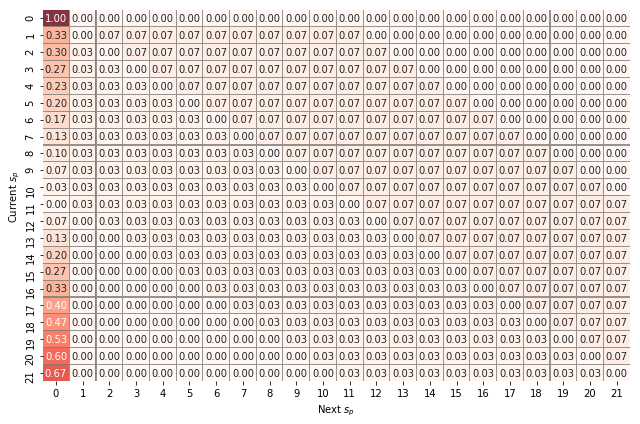

In [3]:
# Visualize player sum transition probability
fig, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(P_p, ax=ax, cmap="Reds", alpha=0.8, linewidths=0.1, linecolor="gray", 
            annot=True, fmt=".2f", cbar=False)
ax.set_xticklabels(range(22))
ax.set_yticklabels(range(22))
ax.set_xlabel("Next $s_p$")
ax.set_ylabel("Current $s_p$")
fig.tight_layout()
None

**Remarks**

Chance of "bust" increases as $s_p$ gets close to either end.  This is because of the "low" bust (number below 1).

### Dealer's final sum

Let $s_d \in \{0, \dots 21\}$ be the dealer's sum, with $0$ being "bust".
Dealer keep sticking unless the sum is 17 or larger.  Due to this, there are five possible results: 0 (bust), 17, 18, 19, 21.

The one-step transition probability for $s_d$ is same as that of $s_p$, except that $s_d = 17,\dots 21$ are terminal states.

For this exercise, the distribution of the final result is helpful, with which we can calculate the probability that player wins when he sticks, conditioned on the current sums $s_p$ and $s_d$.
This can be easily calculated by multiplying one-step transition probability until convergence.

In [4]:
P_d = P_p.copy()
P_d[17:] = 0.0
P_d[17:, 17:] = np.eye(5)

for t in range(50):
    tmp = np.matmul(P_d, P_d)
    dev = np.max(np.abs(P_d - tmp))
    print("Iter #%d. deviation = %.5f" % (t, dev))
    P_d = tmp
    
    if dev < 1e-9:
        print("CONVERGED!")
        break

assert np.all(P_d <= 1.0)
assert np.all(P_d >= 0.0)
assert np.allclose(np.sum(P_d, axis=1), 1.0)

Iter #0. deviation = 0.13333
Iter #1. deviation = 0.14234
Iter #2. deviation = 0.08068
Iter #3. deviation = 0.01563
Iter #4. deviation = 0.00044
Iter #5. deviation = 0.00000
Iter #6. deviation = 0.00000
CONVERGED!


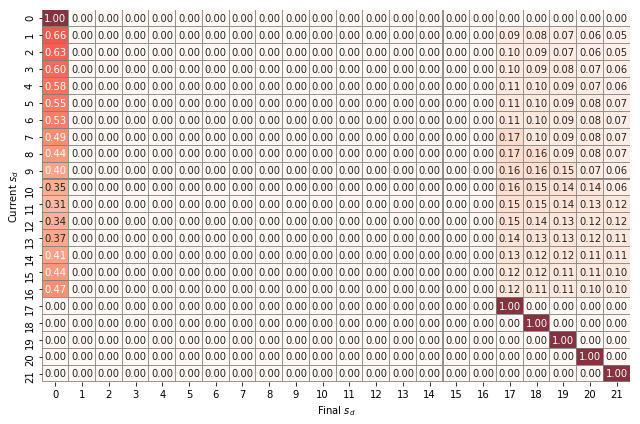

In [5]:
# Visualize player sum transition probability
fig, ax = plt.subplots(figsize=(9, 6))

sns.heatmap(P_d, ax=ax, cmap="Reds", alpha=0.8, linewidths=0.1, linecolor="gray", 
            annot=True, fmt=".2f", cbar=False)
ax.set_xticklabels(range(22))
ax.set_yticklabels(range(22))
ax.set_xlabel("Final $s_d$")
ax.set_ylabel("Current $s_d$")
fig.tight_layout()
None

### Expected reward for hit

When the player hits, he receives -1 reward for "bust" and 0 otherwise.
This can be calculated using the player's transition probability $P_p$ defined above.
Note that we need to make sure that -1 reward is obtained *only once*, *i.e.* he receives no reward when "transitioning" from $s_p=0$ to $s'_p=0$.

In [6]:
R = np.zeros((22, 22))
R[1:, 0] = -1.0
ER_hit = np.sum(P_p * R, axis=-1)

# when hitting with 1, get bust with prob 1/3
assert np.allclose(ER_hit[1], -1.0/3)
# when hitting with 2, get bust with prob 1/3 * 9/10
assert np.allclose(ER_hit[2], -1.0/3*9/10)
# when hitting with 3, get bust with prob 1/3 * 8/10 
assert np.allclose(ER_hit[3], -1.0/3*8/10)

ER_hit = ER_hit.reshape(-1, 1) + np.zeros((22, 11))
ER_hit[:, 0] = 0.0

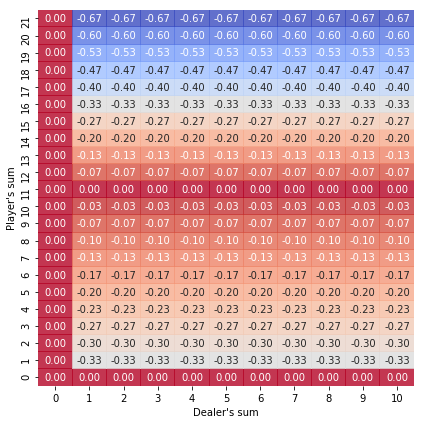

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(ER_hit, ax=ax, cmap="coolwarm", alpha=0.8,
            annot=True, fmt=".2f", cbar=False)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticklabels(range(0, 11))
ax.set_yticklabels(range(0, 22))
ax.set_xlabel("Dealer's sum")
ax.set_ylabel("Player's sum")
fig.tight_layout()
None

### Expected reward for stick

When the player sticks, the dealer keep sticking and end result is realized.
Note that we need to make sure that reward realizes only for the transition from the non-terminal state.

In [8]:
R = np.zeros((22, 22, 22))
R[1:, 1:, 0] = 1.0
for d in range(1, 22):
    R[1:d, 1:17, d] = -1.0
    R[d+1:, 1:17, d] = 1.0
ER_stick = np.sum(R * P_d[None], axis=-1)[:, 0:11]

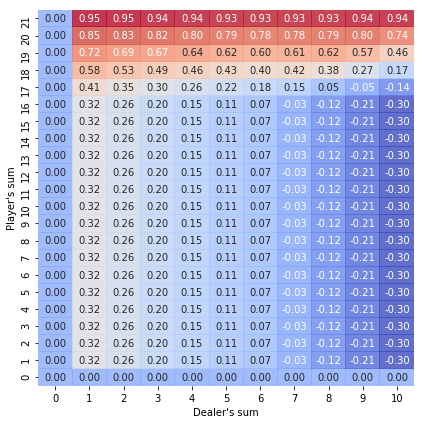

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(ER_stick, ax=ax, cmap="coolwarm", alpha=0.8,
            annot=True, fmt=".2f", cbar=False)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticklabels(range(0, 11))
ax.set_yticklabels(range(0, 22))
ax.set_xlabel("Dealer's sum")
ax.set_ylabel("Player's sum")
fig.tight_layout()
None

### Combine the transition probability and expected reward

In [10]:
P_hit_p = P_p.reshape((22, 1, 22, 1))
P_hit_d = np.eye(11).reshape(1, 11, 1, 11)
P_hit = P_hit_p * P_hit_d
P_hit = P_hit.reshape((22*11, 1, 22*11))

assert np.all(P_hit <= 1.0)
assert np.all(P_hit >= 0.0)
assert np.allclose(np.sum(P_hit, axis=-1), 1.0)

P_stick_p = np.eye(22).reshape(22, 1, 22, 1)
P_stick_d = np.zeros((11, 11))
P_stick_d[:, 0] = 1.0
P_stick_d = P_stick_d.reshape((1, 11, 1, 11))
P_stick = P_stick_p * P_stick_d
P_stick = P_stick.reshape((22*11, 1, 22*11))

assert np.all(P_stick <= 1.0)
assert np.all(P_stick >= 0.0)
assert np.allclose(np.sum(P_stick, axis=-1), 1.0)

P = np.concatenate([P_stick, P_hit], axis=1)
assert P.shape == (22*11, 2, 22*11)

In [11]:
ER = np.concatenate([ER_stick.reshape(22*11, 1), 
                     ER_hit.reshape(22*11, 1)], axis=1)
assert ER.shape == (22*11, 2)

## Value iteration

Value iteration algorithm updates the value function by the Bellman optimality equation:

$$
v'(s) \leftarrow \max_a \left( R(s, a) + \gamma \cdot \sum_s' P\left(s' | s, a\right) v(s') \right)
$$


In [13]:
gamma = 0.999
V = np.zeros((22*11))
for i in range(100):
    V2 = np.max(ER + gamma * np.matmul(P, V), axis=-1)
    dev = np.max(np.abs(V2 - V))
    print("Iter #%d: deviation %.5f" % (i, dev))    
    V = V2
    if dev < 1e-9:
        print("CONVERGED!")
        break

Iter #0: deviation 0.95364
Iter #1: deviation 0.17506
Iter #2: deviation 0.03335
Iter #3: deviation 0.00908
Iter #4: deviation 0.00266
Iter #5: deviation 0.00091
Iter #6: deviation 0.00030
Iter #7: deviation 0.00011
Iter #8: deviation 0.00005
Iter #9: deviation 0.00002
Iter #10: deviation 0.00001
Iter #11: deviation 0.00000
Iter #12: deviation 0.00000
Iter #13: deviation 0.00000
Iter #14: deviation 0.00000
Iter #15: deviation 0.00000
Iter #16: deviation 0.00000
Iter #17: deviation 0.00000
Iter #18: deviation 0.00000
Iter #19: deviation 0.00000
Iter #20: deviation 0.00000
Iter #21: deviation 0.00000
CONVERGED!


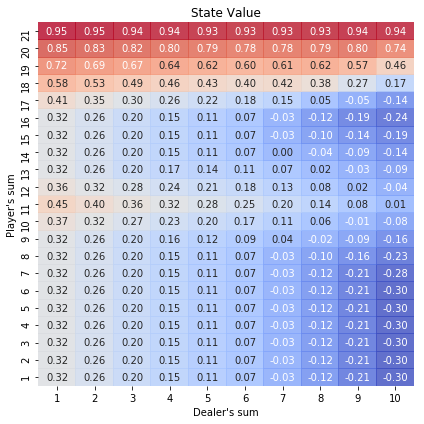

In [14]:
# plot state value function
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(V.reshape((22, 11))[1:, 1:], ax=ax, cmap="coolwarm", alpha=0.8,
            annot=True, fmt=".2f", cbar=False)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticklabels(range(1, 11))
ax.set_yticklabels(range(1, 22))
ax.set_xlabel("Dealer's sum")
ax.set_ylabel("Player's sum")
ax.set_title("State Value")
fig.tight_layout()
None

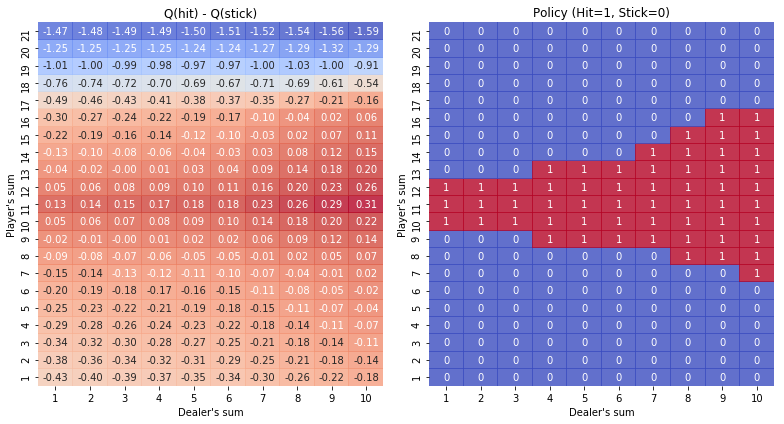

In [15]:
# Plot advantage as Q(hit) - Q(stick)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

Q = ER + gamma * np.matmul(P, V)
Q_diff = Q[:, 1] - Q[:, 0]
sns.heatmap(Q_diff.reshape((22, 11))[1:, 1:], ax=ax1, cmap="coolwarm", alpha=0.8,
            annot=True, fmt=".2f", cbar=False)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticklabels(range(1, 11))
ax1.set_yticklabels(range(1, 22))
ax1.set_xlabel("Dealer's sum")
ax1.set_ylabel("Player's sum")
ax1.set_title("Q(hit) - Q(stick)")

policy = (Q_diff > 0)
sns.heatmap(policy.reshape((22, 11))[1:, 1:], ax=ax2, cmap="coolwarm", alpha=0.8,
            annot=True, fmt="d", cbar=False)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xticklabels(range(1, 11))
ax2.set_yticklabels(range(1, 22))
ax2.set_xlabel("Dealer's sum")
ax2.set_ylabel("Player's sum")
ax2.set_title("Policy (Hit=1, Stick=0)")
fig.tight_layout()
None

### Remark

- In general, the value is increasing in the player's sum and decreasing in the dealer's sum.
- Advantage of "hit" is high if the player's sum is close to 11, where there is no risk of bust. The advantage is higher as the dealer's sum gets higher; The player needs to take risk if the dealer is strong.
- "Stick" is optimal when the current player's sum is small, since there is risk of "low bust".

In [16]:
# save the outcomes, and use them as "correct" answer to evaluate other algorithms.
os.makedirs("result", exist_ok=True)
np.savez("result/dp.npz", 
         V=V.reshape((22, 11))[1:, 1:], 
         Q=Q.reshape((22, 11, 2))[1:, 1:],
         pi=policy.reshape((22, 11))[1:, 1:])

## Policy iteration

Policy iteration is an alternative to the value iteration, where we conduct "policy evaluation" and "policy improvement" at each iteration until convergence.

**Policy evaluation**

Repeat until convergence:

$$
v_{\pi}(s) \leftarrow R(s, \pi(s)) + \gamma \cdot \sum_{s'} P\left(s' | s, \pi(s)\right) v_{\pi}(s') 
$$

**Policy Improvement**

$$
\pi(s) \leftarrow \mathrm{arg} \max_a \left( R(s, a) + \gamma \cdot \sum_{s'} P\left(s' | s, a\right)  v_{\pi}(s') \right)
$$


### Pseudo code

1. Initialize $v$ randomly.
2. Set $\pi \leftarrow$ policy improvement given $v$. 
3. Set $v' \leftarrow$ policy evaluateion given $\pi$.
4. If $v' \approx v$, return $(v, \pi)$.
5. Otherwise set $v \leftarrow v'$ and go to 2.


*Note. Exit criteria should compare $v$ rather than $\pi$ since the greedy policy may not be unique for a given $v$.*

In [17]:
def evaluate_policy(policy, ER, P, gamma, V0=None, tol=1e-3):
    """Predict state value for given polcy"""
    # Algorithm works with any initial value,
    # but starting with previous v speeds up the evaluation
    v = np.zeros((22*11)) if V0 is None else V0
    row_idx = np.arange(len(v))
    converged = False
    for t in range(100):
        new_v = ER[row_idx, policy] + gamma * np.matmul(P[row_idx, policy], v)
        dev = np.max(np.abs(new_v - v))
        v = new_v
        print("  Iter (eval) #%d. Deviation = %.5f" % (t, dev))
        if dev < tol:
            converged = True
            print("  CONVERGED!")
            break
    if not converged:
        print("WARN: policy evaluation did not converge (final deviation = %.5f)" % dev)
    return v

def improve_policy(V, ER, P, gamma):
    """Return greedy policy for given V"""
    q = ER + gamma * np.matmul(P, V)
    policy = np.argmax(q, axis=-1)
    return policy

In [18]:
V_pi = np.zeros((22*11))
for t in range(1000):
    policy_pi = improve_policy(V_pi, ER, P, gamma)
    new_V = evaluate_policy(policy_pi, ER, P, gamma, V0=V_pi)

    dev = np.max(np.abs(new_V - V_pi))
    print("Iter #%d. Deviation = %.5f" % (t, dev))
    if dev < 1e-9:
        print("CONVERGED!")
        break
    V_pi = new_V

  Iter (eval) #0. Deviation = 0.95364
  Iter (eval) #1. Deviation = 0.17506
  Iter (eval) #2. Deviation = 0.04172
  Iter (eval) #3. Deviation = 0.01113
  Iter (eval) #4. Deviation = 0.00661
  Iter (eval) #5. Deviation = 0.00360
  Iter (eval) #6. Deviation = 0.00200
  Iter (eval) #7. Deviation = 0.00111
  Iter (eval) #8. Deviation = 0.00061
  CONVERGED!
Iter #0. Deviation = 0.95364
  Iter (eval) #0. Deviation = 0.16944
  Iter (eval) #1. Deviation = 0.02363
  Iter (eval) #2. Deviation = 0.00616
  Iter (eval) #3. Deviation = 0.00226
  Iter (eval) #4. Deviation = 0.00087
  CONVERGED!
Iter #1. Deviation = 0.18271
  Iter (eval) #0. Deviation = 0.02257
  Iter (eval) #1. Deviation = 0.00075
  CONVERGED!
Iter #2. Deviation = 0.02257
  Iter (eval) #0. Deviation = 0.00039
  CONVERGED!
Iter #3. Deviation = 0.00039
  Iter (eval) #0. Deviation = 0.00016
  CONVERGED!
Iter #4. Deviation = 0.00016
  Iter (eval) #0. Deviation = 0.00007
  CONVERGED!
Iter #5. Deviation = 0.00007
  Iter (eval) #0. Deviatio

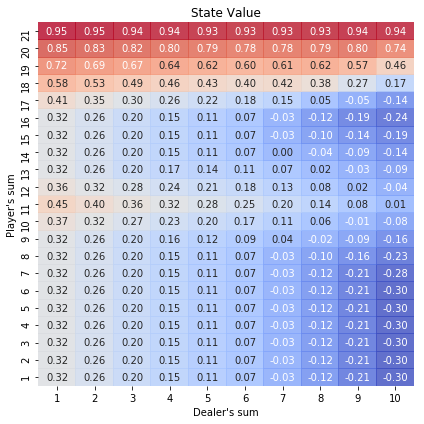

In [19]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(V_pi.reshape((22, 11))[1:, 1:], ax=ax, cmap="coolwarm", alpha=0.8,
            annot=True, fmt=".2f", cbar=False)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xticklabels(range(1, 11))
ax.set_yticklabels(range(1, 22))
ax.set_xlabel("Dealer's sum")
ax.set_ylabel("Player's sum")
ax.set_title("State Value")
fig.tight_layout()
None

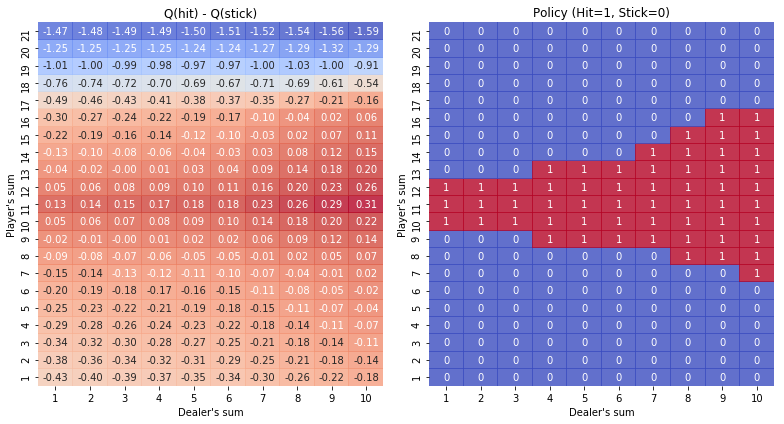

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

Q_pi = ER + gamma * np.matmul(P, V_pi)
Q_pi_diff = Q_pi[:, 1] - Q_pi[:, 0]
sns.heatmap(Q_pi_diff.reshape((22, 11))[1:, 1:], ax=ax1, cmap="coolwarm", alpha=0.8,
            annot=True, fmt=".2f", cbar=False)
ax1.set_ylim(ax1.get_ylim()[::-1])
ax1.set_xticklabels(range(1, 11))
ax1.set_yticklabels(range(1, 22))
ax1.set_xlabel("Dealer's sum")
ax1.set_ylabel("Player's sum")
ax1.set_title("Q(hit) - Q(stick)")

sns.heatmap(policy_pi.reshape((22, 11))[1:, 1:], ax=ax2, cmap="coolwarm", alpha=0.8,
            annot=True, fmt="d", cbar=False)
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xticklabels(range(1, 11))
ax2.set_yticklabels(range(1, 22))
ax2.set_xlabel("Dealer's sum")
ax2.set_ylabel("Player's sum")
ax2.set_title("Policy (Hit=1, Stick=0)")
fig.tight_layout()
None

In [21]:
# Confirm that value iteration and policy iteration obtained equivalent result.
print("Difference in V = %.5f" % np.max(np.abs(V - V_pi)))
print("Difference in Q = %.5f" % np.max(np.abs(Q - Q_pi)))
print("Difference in Policy = %d" % np.sum(policy != policy_pi))

Difference in V = 0.00000
Difference in Q = 0.00000
Difference in Policy = 0
